In [1]:
from class_model import ClassificationModel
import numpy as np
import pandas as pd
import re
from textwrap import wrap
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import 

plt.rcParams.update({'font.size': 18})

In [2]:
X_train = np.loadtxt("data/X_train.txt")
y_train = np.loadtxt("data/y_train.txt")
X_val = np.loadtxt("data/X_val.txt")
y_val = np.loadtxt("data/y_val.txt")
X_test = np.loadtxt("data/X_test.txt")
y_test = np.loadtxt("data/y_test.txt")

In [103]:
results

,Loss: train,Loss: val,Loss: test,Acc: train,Acc: val,Acc: test,Num epochs,Time (s)
0,0.5477,0.5913,0.6285,0.7158,0.6946,0.6490,166,12.2955


In [102]:
clm = ClassificationModel((X_train, y_train), (X_val, y_val), (X_test, y_test),
                              caption=f"Best model",
                              optim="sgd",
                              lr=0.01, mom=0.00,
                              n_hidden_layers=1, n_hidden_neurons=25, n_reps=1)
r, results, _ = clm.evaluate(write=False)
y_pred_train = clm.model.predict(X_train).reshape(-1)
y_pred_val = clm.model.predict(X_val).reshape(-1)
y_pred_test = clm.model.predict(X_test).reshape(-1)

summary_table(y_train, y_pred_train, y_val, y_pred_val, y_test, y_pred_test)

Best model: starting run 1 out of 1


,train,val,test
loss,0.5477,0.5913,0.6285
accuracy,0.7158,0.6946,0.6490
tpr/ recall,0.7425,0.6707,0.6827
fpr,0.3112,0.2824,0.3846
precision,0.7066,0.6962,0.6396
f1 score,0.7241,0.6832,0.6605
auc,0.7959,0.7750,0.7012


In [101]:
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

logreg = LogisticRegression()
logreg.fit(X_train_val, y_train_val)

y_pred_train = logreg.predict_proba(X_train)[:, 1]
y_pred_val = logreg.predict_proba(X_val)[:, 1]
y_pred_test = logreg.predict_proba(X_test)[:, 1]

summary_table(y_train, y_pred_train, y_val, y_pred_val, y_test, y_pred_test)

,train,val,test
loss,0.6133,0.5908,0.6594
accuracy,0.6586,0.7186,0.6202
tpr/ recall,0.6377,0.6951,0.6058
fpr,0.3202,0.2588,0.3654
precision,0.6677,0.7215,0.6238
f1 score,0.6524,0.7081,0.6146
auc,0.7209,0.7835,0.6586


,Loss: train,Loss: val,Loss: test,Acc: train,Acc: val,Acc: test,Num epochs,Time (s)
0,0.5359,0.5981,0.6522,0.7383,0.6946,0.6490,145,9.8664


In [81]:
[roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val), roc_auc_score(y_test, y_pred_test)]

0.8109882953126978

In [72]:
def my_confusion_matrix(y_true, y_pred):
    df_conf_mat = pd.DataFrame(confusion_matrix(y_true, np.where(y_pred > 0.5, 1, 0)))
    df_conf_mat.rename(columns={0: "Pred negative", 1: "Pred positive"},
                       index={0: "Actual negative", 1: "Actual positive"}, inplace=True)
    df_conf_mat.loc["Total pred"] = df_conf_mat.sum(axis=0)
    df_conf_mat["Total actual"] = df_conf_mat.sum(axis=1)
    return df_conf_mat

In [100]:
# metrics
def my_confusion_matrix(y_true, y_pred):
    df_conf_mat = pd.DataFrame(confusion_matrix(y_true, np.where(y_pred > 0.5, 1, 0)))
    df_conf_mat.rename(columns={0: "Pred negative", 1: "Pred positive"},
                       index={0: "Actual negative", 1: "Actual positive"}, inplace=True)
    df_conf_mat.loc["Total pred"] = df_conf_mat.sum(axis=0)
    df_conf_mat["Total actual"] = df_conf_mat.sum(axis=1)
    return df_conf_mat

def tpr(y_true, y_pred):
    confusion_mat = my_confusion_matrix(y_true, y_pred)
    return (confusion_mat.loc["Actual positive", "Pred positive"] / 
            confusion_mat.loc["Actual positive", "Total actual"])

def fpr(y_true, y_pred):
    confusion_mat = my_confusion_matrix(y_true, y_pred)
    return (confusion_mat.loc["Actual negative", "Pred positive"] / 
            confusion_mat.loc["Actual negative", "Total actual"])

def precision(y_true, y_pred):
    confusion_mat = my_confusion_matrix(y_true, y_pred)
    return (confusion_mat.loc["Actual positive", "Pred positive"] / 
            confusion_mat.loc["Total pred", "Pred positive"])

def log_loss(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def accuracy(y_true, y_pred):
    return np.mean(y_true == np.where(y_pred > 0.5, 1, 0))

def my_f1_score(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = tpr(y_true, y_pred)
    return 2 * precision_ * recall_ / (precision_ + recall_)

def summary_table(y_train, y_pred_train, y_val, y_pred_val, y_test, y_pred_test):
    df = pd.DataFrame({
        "loss": [log_loss(y_train, y_pred_train), log_loss(y_val, y_pred_val), log_loss(y_test, y_pred_test)],
        "accuracy": [accuracy(y_train, y_pred_train), accuracy(y_val, y_pred_val), accuracy(y_test, y_pred_test)],
        "tpr/ recall": [tpr(y_train, y_pred_train), tpr(y_val, y_pred_val), tpr(y_test, y_pred_test)],
        "fpr": [fpr(y_train, y_pred_train), fpr(y_val, y_pred_val), fpr(y_test, y_pred_test)],
        "precision": [precision(y_train, y_pred_train), precision(y_val, y_pred_val), precision(y_test, y_pred_test)],
        "f1 score": [my_f1_score(y_train, y_pred_train), my_f1_score(y_val, y_pred_val), my_f1_score(y_test, y_pred_test)],
        "auc": [roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val), roc_auc_score(y_test, y_pred_test)]}, 
        index=["train", "val", "test"]).T

    return df

# Scratch

In [11]:
clm = ClassificationModel((X_train, y_train), (X_val, y_val), (X_test, y_test),
                                  caption=f"Best model", 
                          lr=0.01, mom=0.01,
                          n_hidden_layers=1, n_hidden_neurons=25, n_reps=1)
r, results, _ = clm.evaluate(write=False)
model = clm.model

Best model: starting run 1 out of 1


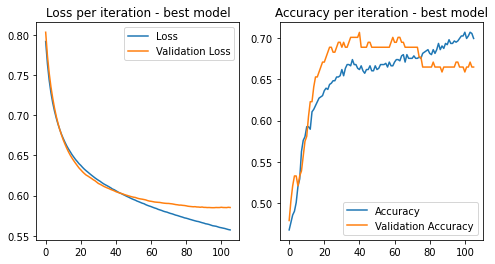

In [13]:
fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f"Loss per iteration - best model")
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title(f"Accuracy per iteration - best model")
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

In [14]:
roc_train = roc_curve(y_train, y_pred_train)
roc_val = roc_curve(y_val, y_pred_val)
roc_test = roc_curve(y_test, y_pred_test)

NameError: name 'y_pred_train' is not defined

In [10]:
data = pd.read_csv("data/data.csv")
X_train = np.loadtxt("data/X_train.txt")
y_train = np.loadtxt("data/y_train.txt")
X_val = np.loadtxt("data/X_val.txt")
y_val = np.loadtxt("data/y_val.txt")
X_test = np.loadtxt("data/X_test.txt")
y_test = np.loadtxt("data/y_test.txt")

# clm = ClassificationModel((X_train, y_train), (X_val, y_val), (X_test, y_test),
#                               caption=f"Best model",
#                               optim="sgd",
#                               lr=0.01, mom=0.00,
#                               n_hidden_layers=1, n_hidden_neurons=25, n_reps=1)
# r, results, _ = clm.evaluate(write=False)

# y_pred_train = clm.model.predict(X_train)
# y_pred_val = clm.model.predict(X_val)
# y_pred_test = clm.model.predict(X_test)

Best model: starting run 1 out of 1


In [39]:
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

In [45]:
logreg = LogisticRegression()

In [46]:
logreg.fit(X_train_val, y_train_val)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
logreg.score(X_train, y_train)

0.6586466165413534

In [54]:
np.mean(logreg.predict(X_train) == y_train)

0.6586466165413534